# Parallelization

On a computer with multiple CPUs the turbulence box(es) can be generated in parallel. In Hipersim, two levels of parallelization are available:
-  Single box parallelization: All CPUs are used to reduce the time it takes to generate a single box. Boxes are generated sequentially (one at the time).
-  Multi box parallelization: All boxes are generated by one CPU. Multiple boxes are generated in parallel.


In [1]:
# imports and default args
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
import multiprocessing
from tqdm.auto import tqdm
from hipersim import MannTurbulenceField, MannSpectralTensor
from hipersim.turbgen.spectral_tensor import random_generator_seq, random_generator_par

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.chdir('/tmp') # switch to ram disk on Sophia HPC
args_dict = dict(alphaepsilon=.1, L=33.6, Gamma=3.9, Nxyz=(1024,64,64), dxyz=(1,1,1), seed=1)

## Single box parallization

The turbulence generation process can be speed up, by utilizing multiple CPUs. This is done by setting `n_cpu` to the desired number of CPUs or `None` to utilized all CPUs on the system.

On a HPC node with 32 CPUs and 256GB memory, it is possible to generate a field with 38880x1792x64 points in less than 10min

In [2]:
def generate_single_box(n_cpu):
    start_time = time.time()
    from hipersim.turbgen.spectral_tensor import random_generator_seq, random_generator_par
    mtf = MannTurbulenceField.generate(**args_dict,
                                       n_cpu=n_cpu, # defaults to 1
                                       random_generator=random_generator_par, # default when n_cpu!=1
                                       # random_generator=random_generator_seq, # default when n_cpu==1
                                   )
    mtf.to_hawc2()
    return time.time()-start_time   

In [3]:
n_cpu_lst = np.array([1,2,4,8,16,32])
t1_lst = np.array([generate_single_box(n_cpu) for n_cpu in n_cpu_lst])
t2_lst = np.array([generate_single_box(n_cpu) for n_cpu in n_cpu_lst])

initialize pool with 1 cpus
initialize pool with 2 cpus
initialize pool with 4 cpus
initialize pool with 8 cpus
initialize pool with 16 cpus
initialize pool with 32 cpus


Process ForkPoolWorker-62:
Process ForkPoolWorker-61:
Process ForkPoolWorker-60:
Process ForkPoolWorker-33:
Process ForkPoolWorker-35:
Process ForkPoolWorker-42:
Process ForkPoolWorker-15:
Process ForkPoolWorker-50:
Process ForkPoolWorker-25:
Process ForkPoolWorker-58:
Process ForkPoolWorker-28:
Process ForkPoolWorker-21:
Process ForkPoolWorker-45:
Process ForkPoolWorker-57:
Process ForkPoolWorker-51:
Process ForkPoolWorker-36:
Process ForkPoolWorker-18:
Process ForkPoolWorker-30:
Process ForkPoolWorker-37:
Process ForkPoolWorker-8:
Process ForkPoolWorker-53:
Process ForkPoolWorker-44:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Process ForkPoolWorker-39:
Process ForkPoolWorker-54:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-3:
Traceback (most recent call last):
T

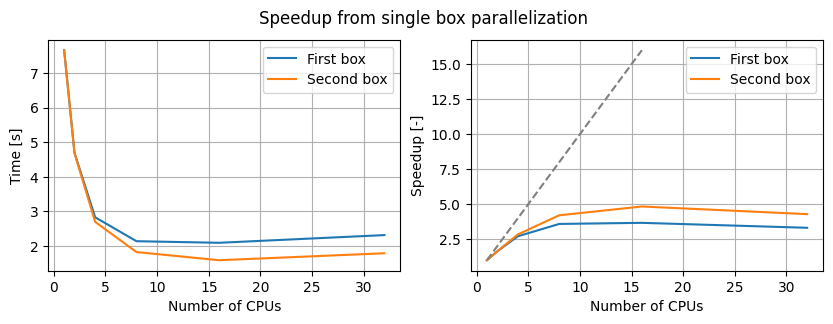

In [4]:
ax1,ax2 = plt.subplots(1,2, figsize=(10,3))[1]
plt.suptitle("Speedup from single box parallelization")
ax1.plot(n_cpu_lst, t1_lst, label='First box')
ax1.plot(n_cpu_lst, t2_lst, label='Second box')
ax1.set_ylabel('Time [s]')
ax2.plot(n_cpu_lst, t1_lst[0] / t1_lst, label='First box')
ax2.plot(n_cpu_lst, t2_lst[0] / t2_lst, label='Second box')
ax2.plot(n_cpu_lst[:5], n_cpu_lst[:5],'--', color='gray')
ax2.set_ylabel('Speedup [-]')
for ax in [ax1,ax2]:
    ax.set_xlabel('Number of CPUs')
    ax.grid()
    ax.legend()

**Note**
- The speed up, from parallelization typically increases with the number of points in the turbulence box, i.e. higher speed up may be seed for larger boxes
- The speed up is system dependent. In this example a HPC node with 2x16 CPUs are used.
- In case, you need to generate many turbulence boxes, it is typically more efficient to use one CPU per box, see [Multi box in parallelization](#Multi-box-parallelization)
- On Windows, it takes some time to start the subprocesses, which may sacrifies the speed up, but subsequent calls will be faster.
- The final turbulence box is highly dependent on the random numbers, which are multiplied to the spectral tensor. The  `random_generator` argument defaults to `random_generator_seq` when `n_cpu=1`(default) and to `random_generator_par` in all other cases. The random numbers generated by `random_generator_par` depends on the `n_cpu` and will be different from the numbers generated by `random_generator_seq`. This means that you need to set `random_generator=random_generator_seq` to get exactly the same box from parallel and sequential execution.

## Multi box parallelization

In case, you need to generate many turbulence boxes, it is typically more efficient to use one CPU per box. 

To do this, you can run a script like this:

```python
from hipersim import MannTurbulenceField
import multiprocessing


def generate(args_dict):
    mtf = MannTurbulenceField.generate(**args_dict)
    # mtf.to_hawc2() # uncomment to save the turbulence boxes
    return mtf


# default arguments
args_dict = dict(alphaepsilon=.1, L=33.6, Gamma=3.9, Nxyz=(1024, 64, 64), dxyz=(2, 2, 2), seed=1)

# make list of arguments (dict), overwriting dx
args_dict_lst = [{**args_dict, 'dxyz': (dx, 2, 2)} for dx in [1, 2, 3]]


if __name__ == '__main__':
    # generate turbulence boxes in parallel
    with multiprocessing.Pool() as pool:
        mtf_lst = pool.map(generate, args_dict_lst)
```

To run it from a notebook, however, we need to save the `generate` function into a module

In [5]:
%%writefile tmp.py
# write generate function to tmp module
from hipersim import MannTurbulenceField

def generate(args_dict):
    mtf = MannTurbulenceField.generate(**args_dict, n_cpu=1)
    mtf.to_hawc2()
    return mtf

Overwriting tmp.py


After that we can use `multiprocessing` to apply the `tmp.generate` function to a list of arguments, `args_dict_lst`

In [6]:
# import and reload tmp module
import tmp
importlib.reload(tmp)

def generate_32_boxes(n_cpu):
    start_time = time.time()
    # make list of arguments (dict), with different dx
    args_dict_lst = [{**args_dict, 'dxyz':(2+dx/16,2,2)} for dx in range(32)]
    
    # generate turbulence boxes in parallel
    from hipersim.turbgen.spectral_tensor import get_pool
    pool = get_pool(n_cpu) # use already established pool (alt: 'with multiprocessing.Pool(n_cpu) as pool:')
    pool.map(tmp.generate, args_dict_lst)
    return time.time()-start_time

n_cpu_lst = np.array([1,2,4,8,16,32])
t_lst = np.array([generate_32_boxes(n_cpu) for n_cpu in tqdm(n_cpu_lst)])
t_lst

  0%|          | 0/6 [00:00<?, ?it/s]

array([275.20150471, 139.48976564,  71.91936898,  36.16882753,
        18.50893784,  10.54667377])

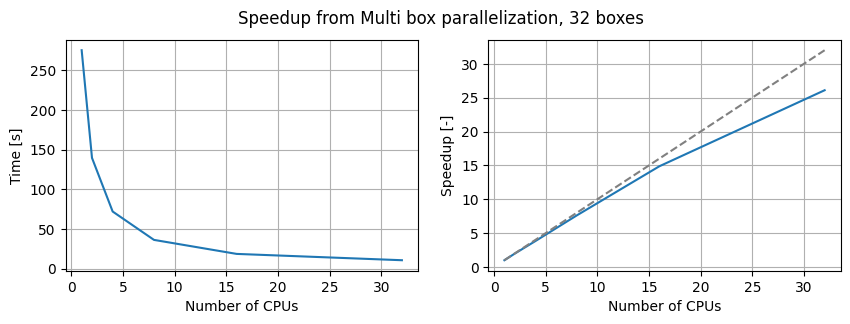

In [7]:
ax1,ax2 = plt.subplots(1,2, figsize=(10,3))[1]
plt.suptitle("Speedup from Multi box parallelization, 32 boxes")
ax1.plot(n_cpu_lst, t_lst)
ax1.set_ylabel('Time [s]')
ax2.plot(n_cpu_lst, t_lst[0] / t_lst)
ax2.plot(n_cpu_lst, n_cpu_lst,'--', color='gray')
ax2.set_ylabel('Speedup [-]')
for ax in [ax1,ax2]:
    ax.set_xlabel('Number of CPUs')
    ax.grid()

### Reuse spectral tensor
In case, you need to generate multiple turbulence boxes where **only** the `seed` and/or `alphaepsilon` varies, the computational time can be further reduced by reusing the spectral tensor.

In [8]:
!rm mannsqrtphi*

In [9]:
!ls mann*

ls: cannot access mann*: No such file or directory


In [10]:
# make spectral tensor with all cpus
start_time = time.time()
from hipersim import MannSpectralTensor
from hipersim.turbgen.spectral_tensor import random_generator_seq
mst = MannSpectralTensor(**args_dict, n_cpu=None, cache_spectral_tensor=True)
mst.spectral_vars # generate spectral tensor
t_spectral_tensor = time.time()-start_time
t_spectral_tensor

2.1426517963409424

We can use the same `tmp.generate` function from above - we just need to add the argument `cache_spectral_tensor=True`

In [11]:
# import and reload tmp module
from tqdm.auto import tqdm
from hipersim.turbgen.spectral_tensor import get_pool
import tmp
import importlib
importlib.reload(tmp)


def generate_32_boxes(n_cpu):
    start_time = time.time()
    # make list of arguments (dict), with different seed
    args_dict_lst = [{**args_dict, 'seed':seed, 'cache_spectral_tensor':True} for seed in range(32)]
      
    # generate turbulence boxes in parallel
    from hipersim.turbgen.spectral_tensor import get_pool
    pool = get_pool(n_cpu) # use already established pool (alt: 'with multiprocessing.Pool(n_cpu) as pool:')
    mtf_lst = pool.map(tmp.generate, args_dict_lst)
    return time.time()-start_time

n_cpu_lst = np.array([1,2,4,8,16,32])
t_reuse_lst = np.array([generate_32_boxes(n_cpu) for n_cpu in tqdm(n_cpu_lst)]) + t_spectral_tensor
t_reuse_lst

  0%|          | 0/6 [00:00<?, ?it/s]

array([69.51701117, 36.22592545, 19.9660337 , 11.55153871,  7.71382976,
        6.49760914])

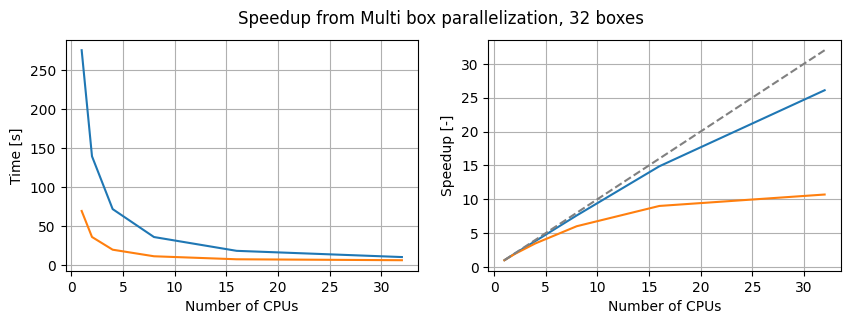

In [12]:
ax1,ax2 = plt.subplots(1,2, figsize=(10,3))[1]
plt.suptitle("Speedup from Multi box parallelization, 32 boxes")
ax1.plot(n_cpu_lst, t_lst, label='New spectral tensor')
ax1.plot(n_cpu_lst, t_reuse_lst, label='Reuse spectral tensor')
ax1.set_ylabel('Time [s]')
ax2.plot(n_cpu_lst, t_lst[0] / t_lst, label='New spectral tensor')
ax2.plot(n_cpu_lst, t_reuse_lst[0] / t_reuse_lst, label='Reuse spectral tensor')
ax2.plot(n_cpu_lst, n_cpu_lst,'--', color='gray')
ax2.set_ylabel('Speedup [-]')
for ax in [ax1,ax2]:
    ax.set_xlabel('Number of CPUs')
    ax.grid()